## **<font color='darkblue'>Previsão de Série Temporal para o blog Cinetour - Viagem de Cinema</font>**

### Série temporal diária de 01/06/2022 até 28/02/2023

- Este estudo foi feito, anteriormente, analisando os acessos ao blog de 06/2010 até 05/2022, com periodicidade mensal. 

## **<font color='purple'>PARTE 1</font>**

### **<font color='purple'>Bibliotecas</font>**

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tbats import TBATS
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

### **<font color='purple'>Leitura da base de dados</font>**

In [2]:
df = pd.read_csv('dados/VC_ST_dia.csv', sep=';', index_col='data')
df.head()

,acessos
data,
01/06/2022,74
02/06/2022,129
03/06/2022,189
04/06/2022,196
05/06/2022,74


### **<font color='purple'>Transformações na coluna de data</font>**

In [3]:
df.index = pd.to_datetime(df.index,
                          format='%d/%m/%Y')
df.index

DatetimeIndex(['2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04',
               '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-08',
               '2022-06-09', '2022-06-10',
               ...
               '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26',
               '2023-02-27', '2023-02-28'],
              dtype='datetime64[ns]', name='data', length=273, freq=None)

In [4]:
# Determinando a frequência como "diária"
df = df.asfreq('D')
df.index

DatetimeIndex(['2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04',
               '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-08',
               '2022-06-09', '2022-06-10',
               ...
               '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26',
               '2023-02-27', '2023-02-28'],
              dtype='datetime64[ns]', name='data', length=273, freq='D')

### **<font color='purple'>Visualização da série temporal</font>**

<AxesSubplot:xlabel='data'>

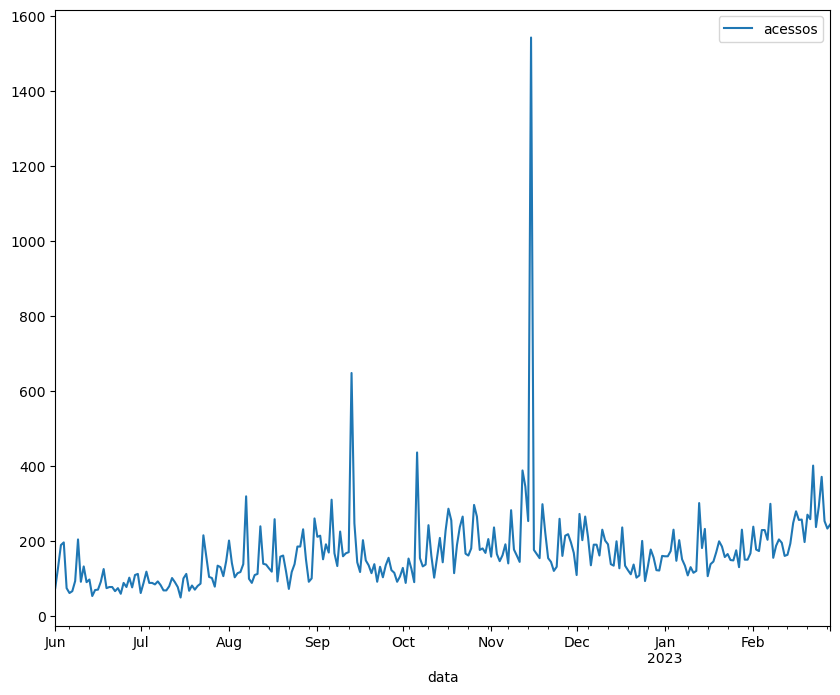

In [5]:
df.plot(figsize=(10,8))

### **<font color='purple'>Decomposição da série temporal</font>**

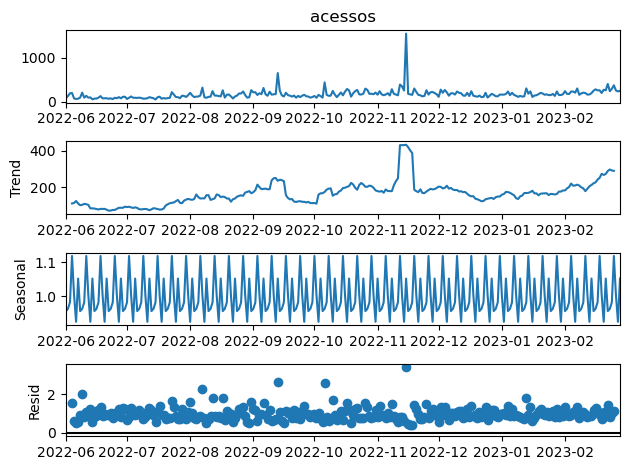

In [6]:
decomposition = seasonal_decompose(x = df.acessos,
                                   model = 'multiplicative')
decomposition.plot();

### **<font color='purple'>Análise de Estacionariedade com Dickey-Fuller aumentado (ADF)</font>**

In [7]:
stationarity = adfuller(df['acessos'])
print('ADF p-value: %F' %stationarity[1])

ADF p-value: 0.000007


### **<font color='purple'>Bases para treino e teste</font>**

In [8]:
# Previsão para 7 dias
test_days = 7

training_set = df.iloc[:-test_days, :]

test_set = df.iloc[-test_days:,:]

In [9]:
training_set.head()

,acessos
data,
2022-06-01,74
2022-06-02,129
2022-06-03,189
2022-06-04,196
2022-06-05,74


In [10]:
test_set.head(7)

,acessos
data,
2023-02-22,401
2023-02-23,237
2023-02-24,292
2023-02-25,371
2023-02-26,253
2023-02-27,233
2023-02-28,244


## **<font color='orange'>PARTE 2</font>**

### **<font color='orange'>MODELAGENS, PREVISÕES & AVALIAÇÕES</font>**

#### **<font color='orange'>COM HOLT WINTERS</font>**

In [11]:
# Modelagem
model_hw = ExponentialSmoothing(training_set['acessos'],
                                trend = 'add',
                                seasonal = 'mul',
                                seasonal_periods = 30).fit()

In [12]:
# Previsões
predictions_hw = pd.Series(model_hw.forecast(steps = test_days)).rename("HW")
predictions_hw.index = test_set.index
predictions_hw.head()

data
2023-02-22    223.374150
2023-02-23    278.017571
2023-02-24    235.071675
2023-02-25    226.674160
2023-02-26    205.535412
Freq: D, Name: HW, dtype: float64

<AxesSubplot:xlabel='data'>

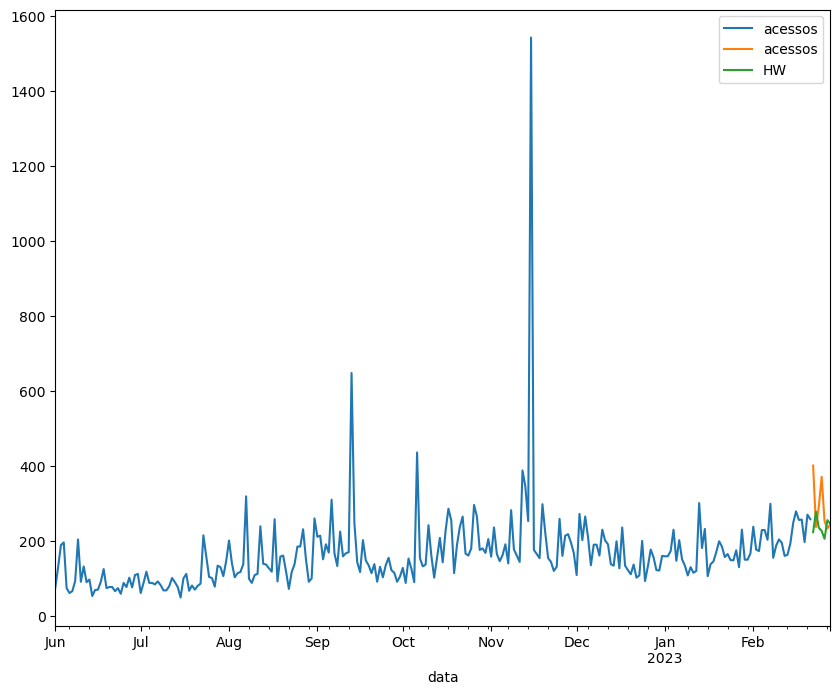

In [13]:
# Visualizações
training_set['acessos'].plot(figsize =(10,8), legend=True)
test_set['acessos'].plot(legend=True)
predictions_hw.plot(legend=True)

In [14]:
# Avaliações deste modelo

# MAE
print(round(mean_absolute_error(test_set['acessos'], predictions_hw), 0))

# RMSE
print(round(np.sqrt(mean_squared_error(test_set['acessos'], predictions_hw)), 0))

# MAPE direto
print(round(mean_absolute_percentage_error(test_set['acessos'], predictions_hw), 4))

70.0
93.0
0.2134


#### **<font color='orange'>COM TBATS</font>**

A sigla TBATS significa:
- **T**rigonometrics seasonality
- **B**ox-cox transformation
- **A**utoregressive moving average
- **T**rend
- **S**easonality

In [15]:
# Modelagem
model_tbats = TBATS(seasonal_periods= [365]).fit(training_set.acessos)

In [16]:
# Previsões
predictions_tbats = pd.Series(model_tbats.forecast(steps = test_days)).rename("TBATS")
predictions_tbats.index = test_set.index
predictions_tbats.head()

data
2023-02-22    245.946074
2023-02-23    247.716783
2023-02-24    249.261872
2023-02-25    250.680645
2023-02-26    252.101356
Freq: D, Name: TBATS, dtype: float64

<AxesSubplot:xlabel='data'>

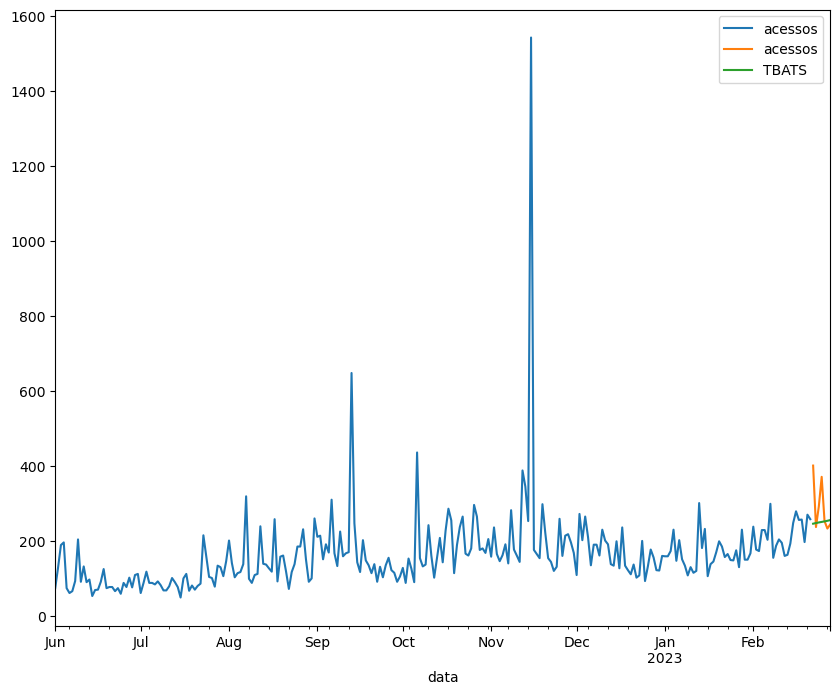

In [17]:
# Visualizações
training_set.acessos.plot(figsize =(10,8), legend=True)
test_set.acessos.plot(legend=True)
predictions_tbats.plot(legend=True)

In [18]:
# Avaliações deste modelo

# MAE
print(round(mean_absolute_error(test_set.acessos, predictions_tbats), 0))

# RMSE
print(round(np.sqrt(mean_squared_error(test_set.acessos, predictions_tbats)), 0))

# MAPE
print(round(mean_absolute_percentage_error(test_set.acessos, predictions_tbats), 4))

52.0
77.0
0.1489


In [19]:
# Função matemática da métrica MAPE
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
round(MAPE(test_set.acessos, predictions_tbats), 2)

14.89

#### **<font color='orange'>COM SARIMAX</font>**

In [20]:
# Modelagem com Auto_ARIMA, sem uso de variáveis exógenas
model_sarimax = auto_arima(y = training_set['acessos'], m=7, seasonal= True, stepwise = False)
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  266
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1608.050
Date:                Sun, 26 Mar 2023   AIC                           3222.100
Time:                        21:10:01   BIC                           3232.839
Sample:                    06-01-2022   HQIC                          3226.415
                         - 02-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4541      0.963      0.472      0.637      -1.433       2.341
ma.L1         -0.9178      0.026    -35.183      0.000      -0.969      -0.867
sigma2      1.084e+04    245.972     44.088      0.000    1.04e+04    1.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):            107019.03
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             8.17
Prob(H) (two-sided):                  0.46   Kurtosis:                       100.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# Previsões
predictions_srx = pd.Series(model_sarimax.predict(n_periods = test_days)).rename("SRX")
predictions_srx.index = test_set.index
predictions_srx.head()

data
2023-02-22    221.272035
2023-02-23    221.726095
2023-02-24    222.180155
2023-02-25    222.634215
2023-02-26    223.088275
Freq: D, Name: SRX, dtype: float64

<AxesSubplot:xlabel='data'>

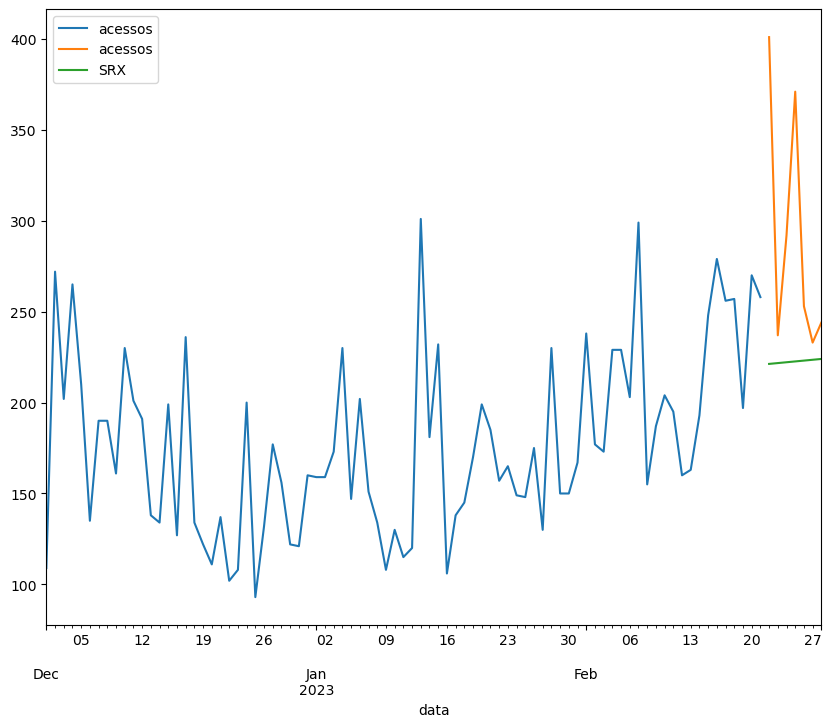

In [22]:
# Visualização parcial (de 12/2022 até 02/2023)
training_set['acessos']['2022-12-01':].plot(figsize =(10,8), legend=True)
test_set['acessos'].plot(legend=True)
predictions_srx.plot(legend=True)

In [23]:
# Avaliações deste modelo

# MAE
print(round(mean_absolute_error(test_set.acessos, predictions_srx), 0))

# RMSE
print(round(np.sqrt(mean_squared_error(test_set.acessos, predictions_srx)), 0))

# MAPE direto
print(round(mean_absolute_percentage_error(test_set.acessos, predictions_srx), 4))

68.0
93.0
0.1989


#### **<font color='darkblue'>RESULTADO</font>**

Dos três modelos analisados, o **<font color='orange'>TBATS</font>** foi o que cometeu menos erros, realizando, assim, as melhores previsões para esta série de tempo diária.
- MAE= 52.0;
- RMSE= 77.0;
- MAPE = 14.89%